# Домашнее задание № 2. Мешок слов

## Задание 1 (3 балла)

У векторайзеров в sklearn есть встроенная токенизация на регулярных выражениях. Найдите способо заменить её на кастомную токенизацию

Обучите векторайзер с дефолтной токенизацией и с токенизацией razdel.tokenize. Обучите классификатор с каждым из векторизаторов. Сравните метрики и выберете победителя. 

(в вашей тетрадке должен быть код обучения и все метрики; если вы сдаете в .py файлах то сохраните полученные метрики в отдельном файле или в комментариях)

In [40]:
import pandas as pd
from razdel import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

from IPython.display import Image
from IPython.core.display import HTML 

In [41]:
data = pd.read_csv('labeled.csv')

In [42]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


<AxesSubplot:>

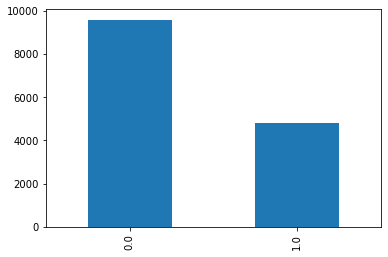

In [43]:
data['toxic'].value_counts().plot(kind="bar")

In [44]:
train, test = train_test_split(data, test_size=0.1, shuffle=True)

In [45]:
y = train.toxic.values
y_test = test.toxic.values

In [46]:
# дефолтная токенизация
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train.comment)
X_1 = vectorizer.transform(test.comment) 

In [47]:
X.shape

(12970, 63843)

In [48]:
def razdel_tokenize (text):
    tokens = list (tokenize(text))
    tokens = [_.text for _ in tokens]
    return (tokens)

# векторизация с токенизацией из razdel
custom_vectorizer = CountVectorizer(tokenizer = razdel_tokenize)
X_razdel = custom_vectorizer.fit_transform (train.comment)
X_1 = custom_vectorizer.transform (test.comment) 

In [49]:
X_razdel.shape

(12970, 64777)

In [50]:
# дефолтный классификатор
clf = LogisticRegression(C=0.1, class_weight='balanced')
clf.fit(X, y)

# razdel классификатор
clf_razdel = LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)
clf_razdel.fit(X_razdel, y)

# предсказания
preds = clf.predict(X)
preds_razdel = clf_razdel.predict(X_1)

In [55]:
# дефолтная метрика
print(classification_report(y, preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      8645
         1.0       0.83      0.96      0.89      4325

    accuracy                           0.92     12970
   macro avg       0.90      0.93      0.91     12970
weighted avg       0.93      0.92      0.92     12970



In [57]:
# метрика для razdel 
print(classification_report(y_test, preds_razdel, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.92      0.86      0.88       941
         1.0       0.76      0.85      0.80       501

    accuracy                           0.85      1442
   macro avg       0.84      0.85      0.84      1442
weighted avg       0.86      0.85      0.86      1442



## Вывод
Векторизация с razdel.tokenize незначительно, но повышает качество классификатора.

## Задание 2 (3 балла)

Преобразуйте таблицу с абсолютными частотностями в семинарской тетрадке в таблицу с tfidf значениями. (Таблица - https://i.ibb.co/r5Nc2HC/abs-bow.jpg) Формула tfidf есть в семинаре на картнике с пояснениями на английском. 
Считать нужно в питоне. Формат итоговой таблицы может быть любым, главное, чтобы был код и можно было воспроизвести вычисления. 

In [58]:
data = ['я и ты', 'ты и я', 'я я и только я', 'только не я', 'он']
data = [razdel_tokenize(d) for d in data]

vocabulary = ['я', 'ты', 'и', 'только', 'не', 'он']

In [63]:
import numpy as np
import math

def calculate_tf_idf(docs_tokenized, vocab):
    N = len(docs_tokenized)
    V = len(vocab)
    result = np.zeros((N, V))    
    for i in range(0, N):
        doc = docs_tokenized[i]
        for w in doc:
            j = vocab.index(w)
            # tf
            tf = doc.count(w)/len(doc)
            df = 0
            # df
            for d in docs_tokenized:
                if w in d:
                    df += 1
            idf = np.log10(N/df)
            tfidf = tf * idf
            result[i, j] = round(tfidf, 3)
            
    return result 

In [64]:
print(calculate_tf_idf(data, vocabulary)) 

[[0.032 0.133 0.074 0.    0.    0.   ]
 [0.032 0.133 0.074 0.    0.    0.   ]
 [0.058 0.    0.044 0.08  0.    0.   ]
 [0.032 0.    0.    0.133 0.233 0.   ]
 [0.    0.    0.    0.    0.    0.699]]


## Задание 3 (2 балла)

Обучите 2 любых разных классификатора из семинара. Предскажите токсичность для текстов из тестовой выборки (используйте одну и ту же выборку для обоих классификаторов) и найдите 10 самых токсичных для каждого из классификаторов. Сравните получаемые тексты - какие тексты совпадают, какие отличаются, правда ли тексты токсичные?

Требования к классификаторам:   
а) один должен использовать CountVectorizer, другой TfidfVectorizer  
б) у векторазера должны быть вручную заданы как минимум 5 параметров  
в) у классификатора должно быть задано вручную как минимум 2 параметра  
г)  f1 мера каждого из классификаторов должна быть минимум 0.75  

In [65]:
# MultinomialNB
count_vectorizer = CountVectorizer(tokenizer = razdel_tokenize, 
                            max_features=1000, min_df=5, max_df=0.4)
X = count_vectorizer.fit_transform(train.comment)
X_1 = count_vectorizer.transform(test.comment)

In [66]:
clf = MultinomialNB(alpha=1.)
clf.fit(X, y)
preds = clf.predict(X_1)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86       941
         1.0       0.77      0.62      0.69       501

    accuracy                           0.80      1442
   macro avg       0.79      0.76      0.77      1442
weighted avg       0.80      0.80      0.80      1442



In [69]:
probs = clf.predict_proba(X_1)
toxic_probs = [p[1] for p in probs]

comments = test.comment.tolist()

res = dict(zip(comments, toxic_probs))
res_sorted = {f'{k} : {v}': v for k, v in sorted(res.items(), key=lambda item: item[1])}

top_ten_clf = list(res_sorted)[-10:]

In [70]:
top_ten_clf

['Хохлы не люди. Их нужно обязательно бить, унижать, ссать на лицо. Если же пытаться вести с ними хорошо, как это делали в СССР и докрымской России, то они начинают наглеть и безобразничать. Как и все дегенераты, хохлы вежливое отношение принимают за слабость. Увидел хохлы, плюнь ему в рожу и пни под зад сапогом. Ради счастья всего человечества.\n : 0.9999998102303957',
 'ну ты тупой, блядь, совет выкрутить к тебе исходил из предположения, что у тебя наушники ашановские, которое ты, кстати, и не опровергнул. я и сам его не слушаю на 200 громкости, но всю эту хуйню слышно и без этого\n : 0.9999998578559074',
 'В общем земля тебе пухом братишка, печально что люди с таким хуёвым воспитанием населяют эту планету. быдловатый, сапожный словарный запас. Ну это и ясно, по тебе видно что ты вчера из пещеры вылез, не в обиду, но это выглядит так. Надеюсь что ты прсто троль, иначе просто не представляю как это возможно. Нас негры снежками называют и чё? ты хотя бы раз в жизни черного видел ? Или 

In [79]:
# DecisionTreeClassifier
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_via_razdel, 
                            max_features=1000, min_df=4, max_df=0.4)

X = tfidf_vectorizer.fit_transform(train.comment)
X_1 = tfidf_vectorizer.transform(test.comment)

In [80]:
clf_1 = DecisionTreeClassifier(max_depth=8, class_weight='balanced')
clf_1.fit(X, y)
preds = clf_1.predict(X_1)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.82      0.52      0.64       941
         1.0       0.47      0.78      0.58       501

    accuracy                           0.61      1442
   macro avg       0.64      0.65      0.61      1442
weighted avg       0.70      0.61      0.62      1442



In [83]:
probs = clf_1.predict_proba(X_1)
toxic_probs = [p[1] for p in probs]

comments = test.comment.tolist()

res = dict(zip(comments, toxic_probs))
res_sorted = {f'{k} :  {v}': v for k, v in sorted(res.items(), key=lambda item: item[1])}

top_ten_clf_1 = list(res_sorted)[-10:]

In [84]:
top_ten_clf_1

['Панические атаки и ВСД очень частые спутники проявившейся шизофрении. Не хочу вас пугать, но посетите психиатра. Вам выпишут АД по вашему состоянию. И вы еще очень много лет будете адекватным человеком.\n :  1.0',
 'А,ясно. У вас может быть свое мнение и это похвально,но оно неправильное . Сами же тоже самое пишите. Да вот на деле хватит одного выстрела с танка, сотня-другая убитых и раненных - и все эти 15 миллионов разбегутся по домам. :  1.0',
 'Про последнюю есть отличная песня у The Black Dahlia Murder - Phantom Limb Masturbation)\n :  1.0',
 'Да не, у меня штанишки на резинке )\n :  1.0',
 'У него хохлы были в предках.\n :  1.0',
 'Во первых нахуй нужны ибо эти аккумы говно (низкая ёмкость). Во вторых куча проводов что бы зарядить несколько аккумов. В третьих цена. В итоге одни минусы при одном плюсе. Проще один раз купить нормальную зарядку и несколько аккумов.\n :  1.0',
 'Ну а как же? Только с разрешением в письменном виде хохлы ебутся. А ещё они там снегирей распинают. Не в

## Вывод
Оба классификатора отобрали разные токсичные комментарии, совпал всего один ("Хохлы не люди..."). Есть значительная разница в размерах этих комментариях (заметная). MultinomialNB выбрал более комментарии куда более токсик, чем DecisionTreeClassifier. Это также можно проследить по f1 мере, 0.86/0.69 vs. 0.64/0.58. 